dataset  
- amazon review
http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Books_5.json.gz

- chABSA
https://github.com/chakki-works/chABSA-dataset


https://github.com/ShopRunner/jupyter-notify
```
pip install jupyternotify
```

install mecab and neologd if you use Japanese.

install mecab on mac
```
brew install mecab mecab-ipadic  
pip install mecab-python3
```
install neologd
```
git clone --depth 1 https://github.com/neologd/mecab-ipadic-neologd.git
cd mecab-ipadic-neologd
./bin/install-mecab-ipadic-neologd -n
```

In [1]:
import tensorflow as tf
import numpy as np
import re
import os
import time
import datetime
from tensorflow.contrib.learn import preprocessing
import pickle
import pandas as pd
from numpy.random import choice, randint
import MeCab
from tqdm import tqdm_notebook as tqdm
from matplotlib import pyplot as plt
 


%matplotlib inline
%load_ext jupyternotify

<IPython.core.display.Javascript object>

In [2]:
class TextCNN:

    def __init__(
        self, sequence_length, num_classes, vocab_size, embedding_size, 
        filter_sizes, num_filters, l2_reg_lambda=0.0):


        self.input_x = tf.placeholder(tf.int32, [None, sequence_length], name="input_x")
        self.input_y = tf.placeholder(tf.float32, [None, num_classes], name="input_y")
        self.dropout_keep_prob = tf.placeholder(tf.float32, name="dropout_keep_prob")
        self.loss_weight = tf.placeholder(tf.float32, name="loss_ratio")

        l2_loss = tf.constant(0.0)


        with tf.device('/cpu:0'), tf.name_scope("embedding"):
            self.W = tf.Variable(tf.random_uniform([vocab_size, embedding_size], -1.0, 1.0), name="W")
            self.embedded_chars = tf.nn.embedding_lookup(self.W, self.input_x)
            self.embedded_chars_expanded = tf.expand_dims(self.embedded_chars, -1)

 
        pooled_outputs = []
        for i, filter_size in enumerate(filter_sizes):
            with tf.name_scope("conv-maxpool-%s" % filter_size):
                filter_shape = [filter_size, embedding_size, 1, num_filters]
                W = tf.Variable(tf.truncated_normal(filter_shape, stddev=0.1), name="W")
                b = tf.Variable(tf.constant(0.1, shape=[num_filters]), name="b")
                conv = tf.nn.conv2d(self.embedded_chars_expanded,W,strides=[1, 1, 1, 1],padding="VALID", name="conv")
                bn_conv = self.batch_normalization(conv) 
                h = tf.nn.relu(tf.nn.bias_add(bn_conv, b), name="relu")
                pooled = tf.nn.max_pool(h, ksize=[1, sequence_length - filter_size + 1, 1, 1],strides=[1, 1, 1, 1],padding='VALID',name="pool")
                pooled_outputs.append(pooled)


        num_filters_total = num_filters * len(filter_sizes)
        self.h_pool = tf.concat(pooled_outputs, 3)
        self.h_pool_flat = tf.reshape(self.h_pool, [-1, num_filters_total])
        

        with tf.name_scope("fc-1"):
            W = tf.Variable(tf.truncated_normal([num_filters_total, 1024], stddev=0.01), name="W")
            b = tf.Variable(tf.constant(0.1, shape=[1024]), name="b")
            l2_loss += tf.nn.l2_loss(W)
            l2_loss += tf.nn.l2_loss(b)
            fc_1_output = tf.nn.relu(tf.nn.xw_plus_b(self.h_pool_flat, W, b), name="fc-1-out")


        with tf.name_scope("dropout-1"):
            drop_1 = tf.nn.dropout(fc_1_output, self.dropout_keep_prob)


        with tf.name_scope("fc-2"):
            W = tf.Variable(tf.truncated_normal([1024,1024], stddev=0.01), name="W")
            b = tf.Variable(tf.constant(0.1, shape=[1024]), name="b")
            l2_loss += tf.nn.l2_loss(W)
            l2_loss += tf.nn.l2_loss(b)
            fc_2_output = tf.nn.relu(tf.nn.xw_plus_b(drop_1, W, b), name="fc-2-out")
            
        with tf.name_scope("dropout-2"):
            drop_2 = tf.nn.dropout(fc_2_output, self.dropout_keep_prob)


        with tf.name_scope("fc-3"):
            W = tf.Variable(tf.truncated_normal([1024, num_classes], stddev=0.01), name="W")
            b = tf.Variable(tf.constant(0.1, shape=[num_classes]), name="b")
            l2_loss += tf.nn.l2_loss(W)
            l2_loss += tf.nn.l2_loss(b)
            self.scores = tf.nn.xw_plus_b(drop_2, W, b, name="output")
            self.predictions = tf.argmax(self.scores, 1, name="predictions")
            
            
        with tf.name_scope("loss"):
      
            #　targets * -log(sigmoid(logits)) * pos_weight +　(1 - targets) * -log(1 - sigmoid(logits))
            losses = tf.nn.weighted_cross_entropy_with_logits(logits=self.scores, targets=self.input_y, pos_weight=self.loss_weight)
            #losses = tf.nn.softmax_cross_entropy_with_logits(logits=self.scores, labels=self.input_y)
            self.loss = tf.reduce_mean(losses) + l2_reg_lambda * l2_loss


        with tf.name_scope("accuracy"):
            correct_predictions = tf.equal(self.predictions, tf.argmax(self.input_y, 1))
            self.accuracy = tf.reduce_mean(tf.cast(correct_predictions, "float"), name="accuracy") 
            
            
    def batch_normalization(self, x):
        """
          x -> γ(x-μ)/√（σ^2-ε）　+ β
      
          γ : scale
          μ: mean (first moment)
          σ: variance (second moment)
          β: offset
          ε: to avoid dividing by 0
        """
        epsilon = 1e-5
        dim = x.get_shape()[-1]
        scale = tf.Variable(tf.ones([dim]))
        offset = tf.Variable(tf.zeros([dim]))
        mean, variance = tf.nn.moments(x, [0,1,2])
        return tf.nn.batch_normalization(x, mean, variance, offset, scale, epsilon)

In [3]:
#positive_data_file = "data/amazon/book_pos.txt"
#negative_data_file = "data/amazon/book_neg.txt"

#positive_data_file = "data/chABSA/pos.txt"
#negative_data_file = "data/chABSA/neg.txt"

positive_data_file = "data/amazon_ja/pos.txt"
negative_data_file = "data/amazon_ja/neg.txt"

In [4]:
class Tokenizer:
    def __init__(self):
        mecab = MeCab.Tagger("-Ochasen -d /usr/local/lib/mecab/dic/mecab-ipadic-neologd/")
        self.parser = mecab.parse
            

    def tokenize(self, text):
        text = text.lower()
        l = [line.split("\t") for line in self.parser(text).split("\n")]
        res = " ".join([i[2] for i in l if len(i) >=4]) # has POS.)
        return res

In [5]:
Tokenizer().tokenize("認めたくないものだな。自分自身の若さ故の過ちというものを。")

'認める たい ない もの だ な 。 自分自身 の 若さ故の過ち という もの を 。'

In [6]:
def load_data_and_labels(positive_data_file, negative_data_file, level="char", lang="En"):
       
    positive_examples = list(open(positive_data_file, "r").readlines())
    negative_examples = list(open(negative_data_file, "r").readlines())
    if level == "char":
        positive_examples = [s.replace(" ", "").replace("", " ").lower() for s in positive_examples]
        negative_examples = [s.replace(" ", "").replace("", " ").lower() for s in negative_examples]
    elif level == "word":
        if lang == "Ja":
            t = Tokenizer()
            positive_examples = [t.tokenize(s) for s in positive_examples]
            negative_examples = [t.tokenize(s) for s in negative_examples]
        else:
            positive_examples = [s.strip() for s in positive_examples]
            negative_examples = [s.strip() for s in negative_examples]
    else:
        print("invaid value of 'level'. ('char' or 'word') ")
        
    n_pos = len(positive_examples)
    n_neg = len(negative_examples)
    ratio = n_pos/n_neg
    print("# pos: ", n_pos)
    print("# neg: ", n_neg)
    print("pos/neg:", ratio)
    x_text = positive_examples + negative_examples

    positive_labels = [[0, 1] for _ in positive_examples]
    negative_labels = [[1, 0] for _ in negative_examples]
    y = np.concatenate([positive_labels, negative_labels], 0)
    
    return x_text, y, ratio

In [35]:
def load_data_and_labels_multiclass(files, level="char", lang="En"):
    labels = []
    x_text = []
    n_classes = len(files)
    
    for i, f in enumerate(files):
        positive_examples = list(open(positive_data_file, "r").readlines())
        if level == "char":
            positive_examples = [s.replace(" ", "").replace("", " ").lower() for s in positive_examples]
        elif level == "word":
            if lang == "Ja":
                t = Tokenizer()
                positive_examples = [t.tokenize(s) for s in positive_examples]
            else:
                positive_examples = [s.strip() for s in positive_examples]
        else:
            print("invaid value of 'level'. ('char' or 'word') ")
        
        x_text += positive_examples
        positive_labels = [np.identity(n_classes)[i] for _ in positive_examples]
        labels.append(positive_labels)
    
    y = np.concatenate(labels, 0)
    
    return x_text, y

In [36]:
files = ["data/amazon_ja/r_{}.txt".format(i) for i in range(1,6)]

In [37]:
%%notify
level="char"
x_text, y = load_data_and_labels_multiclass(files, level=level, lang="Ja")
#x_text, y, ratio = load_data_and_labels(positive_data_file, negative_data_file, level="word", lang="Ja")
#x_text, y, ratio = load_data_and_labels(positive_data_file, negative_data_file, level="char", lang="Ja")

<IPython.core.display.Javascript object>

In [38]:
long_doc = True

In [39]:
len(x_text)

311200

In [40]:
x_text[0]

' 書 き 込 み 、 読 み 出 し 、 転 送 速 度 、 い ず れ も 満 足 で す 。 1 6 0 0 万 画 素 の コ ン パ ク ト カ メ ラ タ イ プ の デ ジ カ メ に 入 れ て 撮 影 に 使 い 、 撮 影 後 は カ ー ド リ ー ダ に 接 続 し て 、 撮 影 し た 膨 大 な 量 の 画 像 デ ー タ を サ ム ネ イ ル 表 示 に し た り 、 ピ ッ ク ア ッ プ し た 画 像 を コ ピ ペ し た り し て い ま す が 、 と く に ス ト レ ス を 感 じ る こ と な く 、 快 適 に 使 え て い ま す 。 【 a m a z o n . c o . j p 限 定 】 の 個 体 は 、 s d カ ー ド 本 体 が シ ン プ ル な 小 さ い ボ ー ル 紙 に 挟 ま れ て い る だ け 。 梱 包 は 超 シ ン プ ル で す が 、 実 売 価 格 が 安 く 、 性 能 に も 満 足 出 来 て い る の で 買 っ て 良 か っ た と 思 っ て い ま す 。 耐 久 性 は わ か り ま せ ん 。 そ こ は 要 経 過 観 察 で す ね 。 \n '

In [41]:
length_list = np.array([len(r)for r in x_text])

In [42]:
df = pd.DataFrame(length_list, columns=["length"])
df.head()

,length
0,549
1,67
2,179
3,227
4,311


In [43]:
df.describe(percentiles=[0.5,0.75,0.8,0.9,0.95])

,length
count,311200.000000
mean,244.448683
std,304.022288
min,7.000000
50%,171.000000
75%,285.000000
80%,323.000000
90%,455.000000
95%,633.000000
max,17495.000000


In [44]:
#df.quantile(0.95)["length"]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c20f99550>]],
      dtype=object)

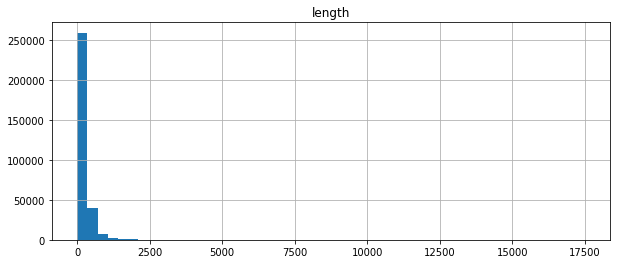

In [45]:
df.hist(bins=50,figsize=(10,4))

In [46]:
max_length = int(df.quantile(0.9)["length"]) #1000
if long_doc:
    print("cut length to ", max_length)
    x_text = [x[:max_length] if len(x) > max_length else x for x in x_text]
length_list = np.array([len(r)for r in x_text])
df = pd.DataFrame(length_list, columns=["length"])
df.describe(percentiles=[0.5,0.75,0.8,0.9,0.95])

cut length to  455


,length
count,311200.000000
mean,207.033451
std,124.179420
min,7.000000
50%,171.000000
75%,285.000000
80%,323.000000
90%,455.000000
95%,455.000000
max,455.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c214b3b00>]],
      dtype=object)

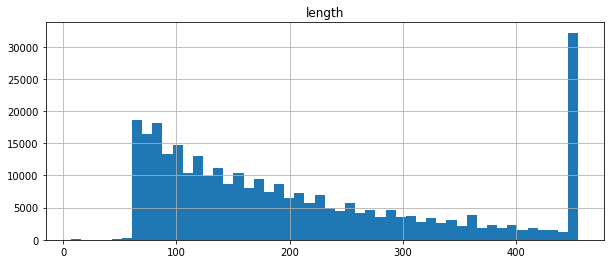

In [47]:
df.hist(bins=50,figsize=(10,4))

In [48]:
vocab_processor = preprocessing.VocabularyProcessor(max_length)

In [49]:
len(x_text)

311200

In [ ]:
%%notify
x = np.array(list(vocab_processor.fit_transform(x_text)))

In [ ]:
test_percentage = 0.01 #0.0010 #0.1

In [ ]:
%%notify
np.random.seed(10)
shuffle_indices = np.random.permutation(np.arange(len(y)))
x_shuffled = x[shuffle_indices]
y_shuffled = y[shuffle_indices]

test_sample_index = -1 * int(test_percentage * float(len(y)))
x_train, x_test = x_shuffled[:test_sample_index], x_shuffled[test_sample_index:]
y_train, y_test = y_shuffled[:test_sample_index], y_shuffled[test_sample_index:]

#del x, y, x_shuffled, y_shuffled

print("Vocabulary Size: {:d}".format(len(vocab_processor.vocabulary_)))
print("Train/Test split: {:d}/{:d}".format(len(y_train), len(y_test)))

In [ ]:
print(x_train.shape)

In [38]:
def batch_iter(data, batch_size, num_epochs, shuffle=True):
    data = np.array(data)
    data_size = len(data)
    num_batches_per_epoch = int((len(data)-1)/batch_size) + 1
    print("num of epochs: ", num_epochs)
    print("num of batches: ", num_batches_per_epoch)
    print("num of step: ", num_batches_per_epoch*num_epochs)
    for epoch in range(num_epochs):
        if shuffle:
            shuffle_indices = np.random.permutation(np.arange(data_size))
            shuffled_data = data[shuffle_indices]
        else:
            shuffled_data = data
        for batch_num in range(num_batches_per_epoch):
            start_index = batch_num * batch_size
            end_index = min((batch_num + 1) * batch_size, data_size)
            yield shuffled_data[start_index:end_index]

In [39]:
sequence_length = x_train.shape[1]
num_classes = y_train.shape[1]
vocab_size = len(vocab_processor.vocabulary_)

In [40]:
embedding_size = 32     
filter_sizes = [2,3,4,5]    
num_filters=128               
dropout_keep_prob=0.5 
l2_reg_lambda=0.1       

In [41]:
TextCNN(sequence_length, num_classes, vocab_size, embedding_size, filter_sizes, num_filters, l2_reg_lambda)

In [34]:
batch_size = 64                  
num_epochs = 200            
evaluate_every = 20         
num_checkpoints = 5
learning_rate = 1e-3

allow_soft_placement = True    
log_device_placement = False  

save_checkpoint = True


#timestamp = str(int(time.time()))
#timestamp = "1525609926"
time_path = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
prefix = ""
#out_dir = os.path.abspath(os.path.join(os.path.curdir, "runs", timestamp, prefix))
out_dir = os.path.join(os.path.curdir, "runs", "{}_cnn_5".format(level), time_path, prefix)
print("Writing to {}\n".format(out_dir))

NameError: name 'level' is not defined

In [43]:
with tf.Graph().as_default():
    session_conf = tf.ConfigProto(
      allow_soft_placement=allow_soft_placement,
      log_device_placement=log_device_placement)
    sess = tf.Session(config=session_conf)
    
    with sess.as_default():
        
        cnn = TextCNN(sequence_length, num_classes, vocab_size, embedding_size, filter_sizes, num_filters, l2_reg_lambda)


        global_step = tf.Variable(0, name="global_step", trainable=False)
        optimizer = tf.train.AdamOptimizer(learning_rate)
        grads_and_vars = optimizer.compute_gradients(cnn.loss)
        train_op = optimizer.apply_gradients(grads_and_vars, global_step=global_step)


        grad_summaries = []
        for g, v in grads_and_vars:
            if g is not None:
                grad_hist_summary = tf.summary.histogram("{}/grad/hist".format(v.name), g)
                sparsity_summary = tf.summary.scalar("{}/grad/sparsity".format(v.name), tf.nn.zero_fraction(g))
                grad_summaries.append(grad_hist_summary)
                grad_summaries.append(sparsity_summary)
        grad_summaries_merged = tf.summary.merge(grad_summaries)


        loss_summary = tf.summary.scalar("loss", cnn.loss)
        acc_summary = tf.summary.scalar("accuracy", cnn.accuracy)

        train_summary_op = tf.summary.merge([loss_summary, acc_summary, grad_summaries_merged])
        
        train_summary_dir = os.path.join(out_dir, "summaries", "train")
        train_summary_writer = tf.summary.FileWriter(train_summary_dir, sess.graph)

        test_summary_op = tf.summary.merge([loss_summary, acc_summary])
        test_summary_dir = os.path.join(out_dir, "summaries", "test")
        test_summary_writer = tf.summary.FileWriter(test_summary_dir, sess.graph)

        if save_checkpoint:
            checkpoint_dir = os.path.abspath(os.path.join(out_dir, "checkpoints"))
            checkpoint_prefix = os.path.join(checkpoint_dir, "model")
            if not os.path.exists(checkpoint_dir):
                os.makedirs(checkpoint_dir)
            saver = tf.train.Saver(tf.global_variables(), max_to_keep=num_checkpoints)

  
        vocab_processor.save(os.path.join(out_dir, "vocab"))


        sess.run(tf.global_variables_initializer())

        def train_step(x_batch, y_batch):
            feed_dict = {
              cnn.input_x: x_batch,
              cnn.input_y: y_batch,
              cnn.dropout_keep_prob: dropout_keep_prob,
              cnn.loss_weight: 1.0#ratio
            }
            _, step, summaries, loss, accuracy = sess.run([train_op, global_step, train_summary_op, cnn.loss, cnn.accuracy], feed_dict)
            
            time_str = datetime.datetime.now().isoformat()
            print("{}: step {}, loss {:g}, acc {:g}".format(time_str, step, loss, accuracy))
            train_summary_writer.add_summary(summaries, step)

        def test_step(x_batch, y_batch, writer=None):
            feed_dict = {
              cnn.input_x: x_batch,
              cnn.input_y: y_batch,
              cnn.dropout_keep_prob: 1.0,
              cnn.loss_weight: 1.0
            }
            step, summaries, loss, accuracy = sess.run([global_step, test_summary_op, cnn.loss, cnn.accuracy], feed_dict)
            time_str = datetime.datetime.now().isoformat()
            print("{}: step {}, loss {:g}, acc {:g}".format(time_str, step, loss, accuracy))
            if writer:
                writer.add_summary(summaries, step)

        batches = batch_iter(list(zip(x_train, y_train)), batch_size, num_epochs)
        for batch in batches:
            x_batch, y_batch = zip(*batch)
            train_step(x_batch, y_batch)
            current_step = tf.train.global_step(sess, global_step)
            
            if current_step % evaluate_every == 0:
                print("\nEvaluation:")
                test_step(x_test, y_test, writer=test_summary_writer)
                print("")
                
            if save_checkpoint and current_step % evaluate_every == 0:
                path = saver.save(sess, checkpoint_prefix, global_step=current_step)
                print("Saved model checkpoint to {}\n".format(path))

INFO:tensorflow:Summary name embedding/W:0/grad/hist is illegal; using embedding/W_0/grad/hist instead.
INFO:tensorflow:Summary name embedding/W:0/grad/sparsity is illegal; using embedding/W_0/grad/sparsity instead.
INFO:tensorflow:Summary name conv-maxpool-2/W:0/grad/hist is illegal; using conv-maxpool-2/W_0/grad/hist instead.
INFO:tensorflow:Summary name conv-maxpool-2/W:0/grad/sparsity is illegal; using conv-maxpool-2/W_0/grad/sparsity instead.
INFO:tensorflow:Summary name conv-maxpool-2/b:0/grad/hist is illegal; using conv-maxpool-2/b_0/grad/hist instead.
INFO:tensorflow:Summary name conv-maxpool-2/b:0/grad/sparsity is illegal; using conv-maxpool-2/b_0/grad/sparsity instead.
INFO:tensorflow:Summary name conv-maxpool-2/Variable:0/grad/hist is illegal; using conv-maxpool-2/Variable_0/grad/hist instead.
INFO:tensorflow:Summary name conv-maxpool-2/Variable:0/grad/sparsity is illegal; using conv-maxpool-2/Variable_0/grad/sparsity instead.
INFO:tensorflow:Summary name conv-maxpool-2/Vari

2018-07-09T21:12:53.312571: step 40, loss 0.892245, acc 0.876634

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/2018_07_09_21_11_51/checkpoints/model-40

2018-07-09T21:12:54.074246: step 41, loss 0.863541, acc 0.890625
2018-07-09T21:12:54.692402: step 42, loss 0.858145, acc 0.875
2018-07-09T21:12:55.206268: step 43, loss 0.798046, acc 0.890625
2018-07-09T21:12:55.702281: step 44, loss 0.774339, acc 0.90625
2018-07-09T21:12:56.163960: step 45, loss 0.773062, acc 0.890625
2018-07-09T21:12:56.686341: step 46, loss 0.860036, acc 0.828125
2018-07-09T21:12:57.184496: step 47, loss 0.686897, acc 0.921875
2018-07-09T21:12:57.752582: step 48, loss 0.863555, acc 0.828125
2018-07-09T21:12:58.304263: step 49, loss 0.675613, acc 0.90625
2018-07-09T21:12:58.819136: step 50, loss 0.582267, acc 0.953125
2018-07-09T21:12:59.368925: step 51, loss 0.550863, acc 0.953125
2018-07-09T21:12:59.942248: step 52, loss 0.665865, acc 0.90625
2018-07-09T21:13:00.473645: step 53, loss 0.60524

2018-07-09T21:15:12.277001: step 151, loss 0.43235, acc 0.875
2018-07-09T21:15:12.794069: step 152, loss 0.316377, acc 0.953125
2018-07-09T21:15:13.315495: step 153, loss 0.46749, acc 0.84375
2018-07-09T21:15:13.827680: step 154, loss 0.42814, acc 0.875
2018-07-09T21:15:14.378879: step 155, loss 0.333193, acc 0.90625
2018-07-09T21:15:14.915711: step 156, loss 0.413441, acc 0.875
2018-07-09T21:15:15.441499: step 157, loss 0.371383, acc 0.90625
2018-07-09T21:15:15.978087: step 158, loss 0.57994, acc 0.828125
2018-07-09T21:15:16.538412: step 159, loss 0.394079, acc 0.890625
2018-07-09T21:15:17.103560: step 160, loss 0.385283, acc 0.90625

Evaluation:
2018-07-09T21:15:26.508282: step 160, loss 0.400536, acc 0.876634

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/2018_07_09_21_11_51/checkpoints/model-160

2018-07-09T21:15:27.354349: step 161, loss 0.311354, acc 0.9375
2018-07-09T21:15:27.896266: step 162, loss 0.427976, acc 0.859375
2018-07-09T21:15:28.425873: step 16

2018-07-09T21:17:28.701031: step 261, loss 0.49051, acc 0.84375
2018-07-09T21:17:29.234173: step 262, loss 0.363111, acc 0.921875
2018-07-09T21:17:29.756154: step 263, loss 0.417328, acc 0.890625
2018-07-09T21:17:30.290865: step 264, loss 0.339767, acc 0.953125
2018-07-09T21:17:30.840391: step 265, loss 0.219166, acc 0.984375
2018-07-09T21:17:31.385526: step 266, loss 0.394191, acc 0.90625
2018-07-09T21:17:31.923183: step 267, loss 0.662688, acc 0.84375
2018-07-09T21:17:32.432292: step 268, loss 0.490903, acc 0.875
2018-07-09T21:17:32.975146: step 269, loss 0.429951, acc 0.875
2018-07-09T21:17:33.510360: step 270, loss 0.397968, acc 0.90625
2018-07-09T21:17:34.046226: step 271, loss 0.395124, acc 0.890625
2018-07-09T21:17:34.580116: step 272, loss 0.526142, acc 0.796875
2018-07-09T21:17:35.113983: step 273, loss 0.363916, acc 0.9375
2018-07-09T21:17:35.657491: step 274, loss 0.508049, acc 0.8125
2018-07-09T21:17:36.182294: step 275, loss 0.437688, acc 0.890625
2018-07-09T21:17:36.70236

2018-07-09T21:19:24.839240: step 373, loss 0.289109, acc 0.96875
2018-07-09T21:19:25.363915: step 374, loss 0.385284, acc 0.890625
2018-07-09T21:19:25.923839: step 375, loss 0.367529, acc 0.890625
2018-07-09T21:19:26.448073: step 376, loss 0.288311, acc 0.9375
2018-07-09T21:19:26.987783: step 377, loss 0.409354, acc 0.890625
2018-07-09T21:19:27.514516: step 378, loss 0.424089, acc 0.875
2018-07-09T21:19:28.077882: step 379, loss 0.422069, acc 0.890625
2018-07-09T21:19:28.650155: step 380, loss 0.408975, acc 0.875

Evaluation:
2018-07-09T21:19:38.001279: step 380, loss 0.38714, acc 0.876634

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/2018_07_09_21_11_51/checkpoints/model-380

2018-07-09T21:19:38.812788: step 381, loss 0.538708, acc 0.796875
2018-07-09T21:19:39.337663: step 382, loss 0.361517, acc 0.921875
2018-07-09T21:19:39.883457: step 383, loss 0.314897, acc 0.953125
2018-07-09T21:19:40.411885: step 384, loss 0.382143, acc 0.90625
2018-07-09T21:19:40.990245:

2018-07-09T21:21:33.945160: step 482, loss 0.413332, acc 0.875
2018-07-09T21:21:34.485542: step 483, loss 0.376454, acc 0.890625
2018-07-09T21:21:35.028974: step 484, loss 0.242753, acc 0.9375
2018-07-09T21:21:35.557533: step 485, loss 0.524497, acc 0.84375
2018-07-09T21:21:36.126517: step 486, loss 0.476229, acc 0.84375
2018-07-09T21:21:36.660229: step 487, loss 0.470635, acc 0.828125
2018-07-09T21:21:37.247183: step 488, loss 0.245569, acc 0.96875
2018-07-09T21:21:37.763436: step 489, loss 0.408179, acc 0.875
2018-07-09T21:21:38.325227: step 490, loss 0.445543, acc 0.84375
2018-07-09T21:21:38.855081: step 491, loss 0.460266, acc 0.84375
2018-07-09T21:21:39.384599: step 492, loss 0.323276, acc 0.921875
2018-07-09T21:21:39.933447: step 493, loss 0.466592, acc 0.828125
2018-07-09T21:21:40.453187: step 494, loss 0.352139, acc 0.90625
2018-07-09T21:21:41.010072: step 495, loss 0.393662, acc 0.875
2018-07-09T21:21:41.550021: step 496, loss 0.424569, acc 0.859375
2018-07-09T21:21:42.125148:

2018-07-09T21:24:11.670105: step 594, loss 0.350487, acc 0.890625
2018-07-09T21:24:12.407361: step 595, loss 0.418454, acc 0.84375
2018-07-09T21:24:13.137656: step 596, loss 0.364987, acc 0.875
2018-07-09T21:24:13.833263: step 597, loss 0.286589, acc 0.921875
2018-07-09T21:24:14.523874: step 598, loss 0.440843, acc 0.859375
2018-07-09T21:24:15.220923: step 599, loss 0.39449, acc 0.859375
2018-07-09T21:24:15.942057: step 600, loss 0.430404, acc 0.859375

Evaluation:
2018-07-09T21:24:37.859546: step 600, loss 0.352563, acc 0.876634

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/2018_07_09_21_11_51/checkpoints/model-600

2018-07-09T21:24:38.989396: step 601, loss 0.328535, acc 0.875
2018-07-09T21:24:39.622124: step 602, loss 0.318188, acc 0.890625
2018-07-09T21:24:40.272097: step 603, loss 0.323271, acc 0.890625
2018-07-09T21:24:40.925135: step 604, loss 0.257536, acc 0.9375
2018-07-09T21:24:41.592376: step 605, loss 0.387617, acc 0.875
2018-07-09T21:24:42.307774: s

2018-07-09T21:26:42.463869: step 703, loss 0.293607, acc 0.921875
2018-07-09T21:26:43.155063: step 704, loss 0.349628, acc 0.890625
2018-07-09T21:26:43.826992: step 705, loss 0.356696, acc 0.90625
2018-07-09T21:26:44.449248: step 706, loss 0.321951, acc 0.9375
2018-07-09T21:26:45.099996: step 707, loss 0.259365, acc 0.90625
2018-07-09T21:26:45.758583: step 708, loss 0.422922, acc 0.828125
2018-07-09T21:26:46.397047: step 709, loss 0.266116, acc 0.90625
2018-07-09T21:26:47.059024: step 710, loss 0.306861, acc 0.890625
2018-07-09T21:26:47.697666: step 711, loss 0.383851, acc 0.84375
2018-07-09T21:26:48.299777: step 712, loss 0.303426, acc 0.921875
2018-07-09T21:26:48.911813: step 713, loss 0.477871, acc 0.8125
2018-07-09T21:26:49.511794: step 714, loss 0.40539, acc 0.828125
2018-07-09T21:26:50.125763: step 715, loss 0.424994, acc 0.84375
2018-07-09T21:26:50.717260: step 716, loss 0.308783, acc 0.9375
2018-07-09T21:26:51.334117: step 717, loss 0.281041, acc 0.90625
2018-07-09T21:26:51.960

2018-07-09T21:28:55.508021: step 815, loss 0.322382, acc 0.859375
2018-07-09T21:28:56.062057: step 816, loss 0.27775, acc 0.890625
2018-07-09T21:28:56.594774: step 817, loss 0.337876, acc 0.859375
2018-07-09T21:28:57.141377: step 818, loss 0.439305, acc 0.859375
2018-07-09T21:28:57.651728: step 819, loss 0.339036, acc 0.875
2018-07-09T21:28:58.166346: step 820, loss 0.383958, acc 0.859375

Evaluation:
2018-07-09T21:29:16.608842: step 820, loss 0.342147, acc 0.876634

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/2018_07_09_21_11_51/checkpoints/model-820

2018-07-09T21:29:17.499701: step 821, loss 0.351547, acc 0.875
2018-07-09T21:29:18.045490: step 822, loss 0.353873, acc 0.859375
2018-07-09T21:29:18.560099: step 823, loss 0.298227, acc 0.890625
2018-07-09T21:29:19.128636: step 824, loss 0.310855, acc 0.90625
2018-07-09T21:29:19.679408: step 825, loss 0.237231, acc 0.953125
2018-07-09T21:29:20.213941: step 826, loss 0.572503, acc 0.78125
2018-07-09T21:29:20.73349

2018-07-09T21:31:37.072047: step 924, loss 0.162779, acc 0.984375
2018-07-09T21:31:37.598711: step 925, loss 0.224454, acc 0.953125
2018-07-09T21:31:38.186999: step 926, loss 0.228229, acc 0.921875
2018-07-09T21:31:38.713110: step 927, loss 0.391685, acc 0.875
2018-07-09T21:31:39.259340: step 928, loss 0.31082, acc 0.84375
2018-07-09T21:31:39.761244: step 929, loss 0.33329, acc 0.875
2018-07-09T21:31:40.283239: step 930, loss 0.292992, acc 0.90625
2018-07-09T21:31:40.795280: step 931, loss 0.272827, acc 0.90625
2018-07-09T21:31:41.302775: step 932, loss 0.327666, acc 0.8125
2018-07-09T21:31:41.818056: step 933, loss 0.283451, acc 0.890625
2018-07-09T21:31:42.356192: step 934, loss 0.262682, acc 0.9375
2018-07-09T21:31:42.872535: step 935, loss 0.323253, acc 0.859375
2018-07-09T21:31:43.406199: step 936, loss 0.267328, acc 0.90625
2018-07-09T21:31:43.971702: step 937, loss 0.233714, acc 0.90625
2018-07-09T21:31:44.554086: step 938, loss 0.263595, acc 0.9375
2018-07-09T21:31:45.075684: s

2018-07-09T21:33:38.547246: step 1035, loss 0.293572, acc 0.890625
2018-07-09T21:33:39.112841: step 1036, loss 0.341769, acc 0.90625
2018-07-09T21:33:39.675419: step 1037, loss 0.278854, acc 0.859375
2018-07-09T21:33:40.374404: step 1038, loss 0.301066, acc 0.875
2018-07-09T21:33:41.064558: step 1039, loss 0.308055, acc 0.859375
2018-07-09T21:33:41.681119: step 1040, loss 0.2719, acc 0.90625

Evaluation:
2018-07-09T21:33:53.013214: step 1040, loss 0.303786, acc 0.878472

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/2018_07_09_21_11_51/checkpoints/model-1040

2018-07-09T21:33:53.845536: step 1041, loss 0.271716, acc 0.9375
2018-07-09T21:33:54.414042: step 1042, loss 0.21897, acc 0.9375
2018-07-09T21:33:54.946875: step 1043, loss 0.311424, acc 0.859375
2018-07-09T21:33:55.524797: step 1044, loss 0.224678, acc 0.90625
2018-07-09T21:33:56.077513: step 1045, loss 0.335209, acc 0.84375
2018-07-09T21:33:56.597987: step 1046, loss 0.22575, acc 0.921875
2018-07-09T21:33:

2018-07-09T21:36:01.338921: step 1142, loss 0.290887, acc 0.90625
2018-07-09T21:36:01.943785: step 1143, loss 0.252783, acc 0.9375
2018-07-09T21:36:02.539665: step 1144, loss 0.212054, acc 0.90625
2018-07-09T21:36:03.196006: step 1145, loss 0.27497, acc 0.890625
2018-07-09T21:36:03.728799: step 1146, loss 0.14148, acc 0.984375
2018-07-09T21:36:04.306955: step 1147, loss 0.16372, acc 0.953125
2018-07-09T21:36:04.829281: step 1148, loss 0.242829, acc 0.90625
2018-07-09T21:36:05.456318: step 1149, loss 0.343472, acc 0.875
2018-07-09T21:36:06.060170: step 1150, loss 0.278935, acc 0.890625
2018-07-09T21:36:06.635412: step 1151, loss 0.381118, acc 0.828125
2018-07-09T21:36:07.231155: step 1152, loss 0.346528, acc 0.921875
2018-07-09T21:36:07.836959: step 1153, loss 0.321485, acc 0.921875
2018-07-09T21:36:08.451529: step 1154, loss 0.33444, acc 0.875
2018-07-09T21:36:09.048571: step 1155, loss 0.229178, acc 0.9375
2018-07-09T21:36:09.633830: step 1156, loss 0.205631, acc 0.9375
2018-07-09T21:

2018-07-09T21:39:13.926507: step 1252, loss 0.270178, acc 0.921875
2018-07-09T21:39:14.554487: step 1253, loss 0.293645, acc 0.875
2018-07-09T21:39:15.177279: step 1254, loss 0.305864, acc 0.875
2018-07-09T21:39:15.752010: step 1255, loss 0.326292, acc 0.90625
2018-07-09T21:39:16.316046: step 1256, loss 0.307016, acc 0.90625
2018-07-09T21:39:16.892337: step 1257, loss 0.286258, acc 0.921875
2018-07-09T21:39:17.455047: step 1258, loss 0.204513, acc 0.9375
2018-07-09T21:39:18.047343: step 1259, loss 0.361834, acc 0.859375
2018-07-09T21:39:18.690684: step 1260, loss 0.25939, acc 0.9375

Evaluation:
2018-07-09T21:39:35.655214: step 1260, loss 0.299133, acc 0.888276

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/2018_07_09_21_11_51/checkpoints/model-1260

2018-07-09T21:39:36.624894: step 1261, loss 0.413829, acc 0.859375
2018-07-09T21:39:37.255896: step 1262, loss 0.23437, acc 0.890625
2018-07-09T21:39:37.805848: step 1263, loss 0.285527, acc 0.90625
2018-07-09T21:39:

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/2018_07_09_21_11_51/checkpoints/model-1360

2018-07-09T21:41:51.957678: step 1361, loss 0.24018, acc 0.90625
2018-07-09T21:41:52.545950: step 1362, loss 0.269222, acc 0.890625
2018-07-09T21:41:53.142043: step 1363, loss 0.278344, acc 0.84375
2018-07-09T21:41:53.736456: step 1364, loss 0.294944, acc 0.890625
2018-07-09T21:41:54.360105: step 1365, loss 0.381389, acc 0.796875
2018-07-09T21:41:54.959064: step 1366, loss 0.334982, acc 0.890625
2018-07-09T21:41:55.493318: step 1367, loss 0.230178, acc 0.953125
2018-07-09T21:41:56.041379: step 1368, loss 0.242791, acc 0.921875
2018-07-09T21:41:56.681789: step 1369, loss 0.269925, acc 0.9375
2018-07-09T21:41:57.276482: step 1370, loss 0.203648, acc 0.953125
2018-07-09T21:41:57.827536: step 1371, loss 0.22197, acc 0.90625
2018-07-09T21:41:58.364056: step 1372, loss 0.391297, acc 0.8125
2018-07-09T21:41:58.919192: step 1373, loss 0.287638, acc 0.90625
2018-07-09T21:41:59.475905

2018-07-09T21:44:01.311235: step 1469, loss 0.32398, acc 0.90625
2018-07-09T21:44:01.767207: step 1470, loss 0.298314, acc 0.859375
2018-07-09T21:44:02.226235: step 1471, loss 0.226584, acc 0.921875
2018-07-09T21:44:02.681017: step 1472, loss 0.224035, acc 0.9375
2018-07-09T21:44:03.195005: step 1473, loss 0.334601, acc 0.859375
2018-07-09T21:44:03.685448: step 1474, loss 0.193582, acc 0.953125
2018-07-09T21:44:04.151386: step 1475, loss 0.26418, acc 0.890625
2018-07-09T21:44:04.629147: step 1476, loss 0.239588, acc 0.921875
2018-07-09T21:44:05.114030: step 1477, loss 0.251663, acc 0.921875
2018-07-09T21:44:05.594743: step 1478, loss 0.260205, acc 0.9375
2018-07-09T21:44:06.102868: step 1479, loss 0.2575, acc 0.90625
2018-07-09T21:44:06.586574: step 1480, loss 0.188373, acc 0.953125

Evaluation:
2018-07-09T21:44:17.207169: step 1480, loss 0.277583, acc 0.912173

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/2018_07_09_21_11_51/checkpoints/model-1480

2018-07-09T2

2018-07-09T21:45:57.710694: step 1579, loss 0.205275, acc 0.921875
2018-07-09T21:45:58.233114: step 1580, loss 0.298854, acc 0.953125

Evaluation:
2018-07-09T21:46:16.433264: step 1580, loss 0.280428, acc 0.918505

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/2018_07_09_21_11_51/checkpoints/model-1580

2018-07-09T21:46:17.331349: step 1581, loss 0.241452, acc 0.96875
2018-07-09T21:46:17.972331: step 1582, loss 0.303831, acc 0.953125
2018-07-09T21:46:18.555904: step 1583, loss 0.249448, acc 0.9375
2018-07-09T21:46:19.087934: step 1584, loss 0.197869, acc 0.921875
2018-07-09T21:46:19.678275: step 1585, loss 0.259079, acc 0.875
2018-07-09T21:46:20.247277: step 1586, loss 0.325962, acc 0.890625
2018-07-09T21:46:20.794407: step 1587, loss 0.216737, acc 0.9375
2018-07-09T21:46:21.359986: step 1588, loss 0.23879, acc 0.90625
2018-07-09T21:46:21.910924: step 1589, loss 0.206431, acc 0.9375
2018-07-09T21:46:22.464115: step 1590, loss 0.256689, acc 0.90625
2018-07-09T21:4

2018-07-09T21:48:27.301167: step 1686, loss 0.291018, acc 0.875
2018-07-09T21:48:27.814391: step 1687, loss 0.297756, acc 0.890625
2018-07-09T21:48:28.335649: step 1688, loss 0.221659, acc 0.96875
2018-07-09T21:48:28.878520: step 1689, loss 0.244368, acc 0.921875
2018-07-09T21:48:29.435060: step 1690, loss 0.295881, acc 0.921875
2018-07-09T21:48:29.976683: step 1691, loss 0.26552, acc 0.9375
2018-07-09T21:48:30.536094: step 1692, loss 0.229641, acc 0.921875
2018-07-09T21:48:31.093287: step 1693, loss 0.252413, acc 0.921875
2018-07-09T21:48:31.641288: step 1694, loss 0.303232, acc 0.890625
2018-07-09T21:48:32.169406: step 1695, loss 0.30051, acc 0.9375
2018-07-09T21:48:32.701640: step 1696, loss 0.210683, acc 0.921875
2018-07-09T21:48:33.242988: step 1697, loss 0.304431, acc 0.859375
2018-07-09T21:48:33.852516: step 1698, loss 0.253421, acc 0.9375
2018-07-09T21:48:34.401626: step 1699, loss 0.321557, acc 0.875
2018-07-09T21:48:34.968264: step 1700, loss 0.188705, acc 0.9375

Evaluation:

2018-07-09T21:51:17.316169: step 1796, loss 0.27537, acc 0.875
2018-07-09T21:51:18.346271: step 1797, loss 0.238152, acc 0.9375
2018-07-09T21:51:19.760325: step 1798, loss 0.164057, acc 0.96875
2018-07-09T21:51:21.049131: step 1799, loss 0.27479, acc 0.875
2018-07-09T21:51:22.357208: step 1800, loss 0.20038, acc 0.9375

Evaluation:
2018-07-09T21:51:43.531293: step 1800, loss 0.272688, acc 0.910743

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/2018_07_09_21_11_51/checkpoints/model-1800

2018-07-09T21:51:44.730927: step 1801, loss 0.337491, acc 0.890625
2018-07-09T21:51:45.653109: step 1802, loss 0.23533, acc 0.953125
2018-07-09T21:51:46.479271: step 1803, loss 0.258702, acc 0.953125
2018-07-09T21:51:47.269054: step 1804, loss 0.294856, acc 0.890625
2018-07-09T21:51:48.120088: step 1805, loss 0.237995, acc 0.953125
2018-07-09T21:51:48.922633: step 1806, loss 0.25537, acc 0.9375
2018-07-09T21:51:49.690442: step 1807, loss 0.178091, acc 0.9375
2018-07-09T21:51:50.52

2018-07-09T21:53:56.231080: step 1903, loss 0.209173, acc 0.953125
2018-07-09T21:53:56.739459: step 1904, loss 0.272669, acc 0.9375
2018-07-09T21:53:57.251882: step 1905, loss 0.272271, acc 0.890625
2018-07-09T21:53:57.781068: step 1906, loss 0.255558, acc 0.921875
2018-07-09T21:53:58.286244: step 1907, loss 0.211003, acc 0.9375
2018-07-09T21:53:58.777599: step 1908, loss 0.31009, acc 0.859375
2018-07-09T21:53:59.363496: step 1909, loss 0.298918, acc 0.859375
2018-07-09T21:53:59.881529: step 1910, loss 0.236104, acc 0.9375
2018-07-09T21:54:00.380624: step 1911, loss 0.243723, acc 0.953125
2018-07-09T21:54:00.946181: step 1912, loss 0.265256, acc 0.90625
2018-07-09T21:54:01.462207: step 1913, loss 0.319916, acc 0.921875
2018-07-09T21:54:02.145180: step 1914, loss 0.261296, acc 0.921875
2018-07-09T21:54:02.713602: step 1915, loss 0.199665, acc 0.96875
2018-07-09T21:54:03.238050: step 1916, loss 0.215185, acc 0.9375
2018-07-09T21:54:03.822676: step 1917, loss 0.238059, acc 0.921875
2018-0

2018-07-09T21:56:17.355018: step 2013, loss 0.400847, acc 0.84375
2018-07-09T21:56:18.092094: step 2014, loss 0.192219, acc 0.9375
2018-07-09T21:56:18.880852: step 2015, loss 0.346021, acc 0.828125
2018-07-09T21:56:19.673617: step 2016, loss 0.232398, acc 0.953125
2018-07-09T21:56:20.545395: step 2017, loss 0.315354, acc 0.890625
2018-07-09T21:56:21.313794: step 2018, loss 0.211931, acc 0.953125
2018-07-09T21:56:22.137205: step 2019, loss 0.203736, acc 0.984375
2018-07-09T21:56:22.895453: step 2020, loss 0.214201, acc 0.96875

Evaluation:
2018-07-09T21:56:55.369972: step 2020, loss 0.271296, acc 0.896855

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/2018_07_09_21_11_51/checkpoints/model-2020

2018-07-09T21:56:56.610679: step 2021, loss 0.199959, acc 0.90625
2018-07-09T21:56:57.367805: step 2022, loss 0.22499, acc 0.921875
2018-07-09T21:56:58.112654: step 2023, loss 0.573513, acc 0.84375
2018-07-09T21:56:58.810400: step 2024, loss 0.197465, acc 0.921875
2018-07-0

2018-07-09T21:58:56.354782: step 2121, loss 0.251498, acc 0.953125
2018-07-09T21:58:56.892051: step 2122, loss 0.223454, acc 0.953125
2018-07-09T21:58:57.430866: step 2123, loss 0.259909, acc 0.90625
2018-07-09T21:58:58.016519: step 2124, loss 0.199616, acc 0.9375
2018-07-09T21:58:58.660147: step 2125, loss 0.197797, acc 0.953125
2018-07-09T21:58:59.247901: step 2126, loss 0.223903, acc 0.953125
2018-07-09T21:58:59.803556: step 2127, loss 0.320556, acc 0.9375
2018-07-09T21:59:00.438222: step 2128, loss 0.2561, acc 0.90625
2018-07-09T21:59:01.078342: step 2129, loss 0.18635, acc 0.9375
2018-07-09T21:59:01.651510: step 2130, loss 0.15082, acc 0.953125
2018-07-09T21:59:02.237152: step 2131, loss 0.213484, acc 0.90625
2018-07-09T21:59:02.924436: step 2132, loss 0.213671, acc 0.921875
2018-07-09T21:59:03.521483: step 2133, loss 0.38264, acc 0.84375
2018-07-09T21:59:04.159844: step 2134, loss 0.219039, acc 0.953125
2018-07-09T21:59:04.775942: step 2135, loss 0.277225, acc 0.90625
2018-07-09T

2018-07-09T22:01:14.681438: step 2231, loss 0.181185, acc 0.96875
2018-07-09T22:01:15.172929: step 2232, loss 0.219009, acc 0.96875
2018-07-09T22:01:15.733790: step 2233, loss 0.200894, acc 0.9375
2018-07-09T22:01:16.215040: step 2234, loss 0.228592, acc 0.953125
2018-07-09T22:01:16.711390: step 2235, loss 0.22397, acc 0.9375
2018-07-09T22:01:17.198079: step 2236, loss 0.153364, acc 0.96875
2018-07-09T22:01:17.654230: step 2237, loss 0.228426, acc 0.921875
2018-07-09T22:01:18.190005: step 2238, loss 0.249231, acc 0.921875
2018-07-09T22:01:18.705324: step 2239, loss 0.189315, acc 0.90625
2018-07-09T22:01:19.178357: step 2240, loss 0.184507, acc 0.953125

Evaluation:
2018-07-09T22:01:29.435248: step 2240, loss 0.258673, acc 0.926879

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/2018_07_09_21_11_51/checkpoints/model-2240

2018-07-09T22:01:30.168013: step 2241, loss 0.217497, acc 0.984375
2018-07-09T22:01:30.649837: step 2242, loss 0.198481, acc 0.921875
2018-07-09T

2018-07-09T22:03:30.366139: step 2340, loss 0.256378, acc 0.922998

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/2018_07_09_21_11_51/checkpoints/model-2340

2018-07-09T22:03:31.103614: step 2341, loss 0.255656, acc 0.90625
2018-07-09T22:03:31.625659: step 2342, loss 0.289981, acc 0.90625
2018-07-09T22:03:32.118894: step 2343, loss 0.199072, acc 0.9375
2018-07-09T22:03:32.685361: step 2344, loss 0.264559, acc 0.90625
2018-07-09T22:03:33.179812: step 2345, loss 0.21116, acc 0.890625
2018-07-09T22:03:33.653694: step 2346, loss 0.256455, acc 0.875
2018-07-09T22:03:34.165749: step 2347, loss 0.213289, acc 0.953125
2018-07-09T22:03:34.660966: step 2348, loss 0.238446, acc 0.9375
2018-07-09T22:03:35.134009: step 2349, loss 0.172425, acc 0.96875
2018-07-09T22:03:35.683361: step 2350, loss 0.149808, acc 1
2018-07-09T22:03:36.258918: step 2351, loss 0.163448, acc 0.96875
2018-07-09T22:03:36.834455: step 2352, loss 0.18213, acc 0.9375
2018-07-09T22:03:37.419835: step 2353,

2018-07-09T22:05:32.014023: step 2448, loss 0.269744, acc 0.9375
2018-07-09T22:05:32.557752: step 2449, loss 0.320216, acc 0.90625
2018-07-09T22:05:33.109378: step 2450, loss 0.229377, acc 0.9375
2018-07-09T22:05:33.636596: step 2451, loss 0.205426, acc 0.9375
2018-07-09T22:05:34.238644: step 2452, loss 0.178922, acc 0.96875
2018-07-09T22:05:34.764191: step 2453, loss 0.209097, acc 0.9375
2018-07-09T22:05:35.301692: step 2454, loss 0.188282, acc 0.9375
2018-07-09T22:05:35.842496: step 2455, loss 0.153567, acc 0.953125
2018-07-09T22:05:36.391878: step 2456, loss 0.189221, acc 0.953125
2018-07-09T22:05:36.902565: step 2457, loss 0.235902, acc 0.9375
2018-07-09T22:05:37.422780: step 2458, loss 0.272711, acc 0.890625
2018-07-09T22:05:37.982171: step 2459, loss 0.176603, acc 0.9375
2018-07-09T22:05:38.494208: step 2460, loss 0.195603, acc 0.953125

Evaluation:
2018-07-09T22:05:57.316690: step 2460, loss 0.265603, acc 0.923815

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/

2018-07-09T22:07:37.917942: step 2558, loss 0.230065, acc 0.890625
2018-07-09T22:07:38.441929: step 2559, loss 0.34908, acc 0.90625
2018-07-09T22:07:38.953802: step 2560, loss 0.253168, acc 0.953125

Evaluation:
2018-07-09T22:07:51.634976: step 2560, loss 0.255195, acc 0.927696

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/2018_07_09_21_11_51/checkpoints/model-2560

2018-07-09T22:07:52.333440: step 2561, loss 0.285246, acc 0.96875
2018-07-09T22:07:52.816898: step 2562, loss 0.231947, acc 1
2018-07-09T22:07:53.308778: step 2563, loss 0.236478, acc 0.921875
2018-07-09T22:07:53.808923: step 2564, loss 0.189106, acc 0.9375
2018-07-09T22:07:54.311184: step 2565, loss 0.26052, acc 0.859375
2018-07-09T22:07:54.801005: step 2566, loss 0.226627, acc 0.890625
2018-07-09T22:07:55.355014: step 2567, loss 0.20038, acc 0.953125
2018-07-09T22:07:55.821617: step 2568, loss 0.188844, acc 0.921875
2018-07-09T22:07:56.313081: step 2569, loss 0.188091, acc 0.96875
2018-07-09T22:07:

2018-07-09T22:10:16.304465: step 2665, loss 0.190395, acc 0.96875
2018-07-09T22:10:16.832032: step 2666, loss 0.15397, acc 0.96875
2018-07-09T22:10:17.351630: step 2667, loss 0.262143, acc 0.859375
2018-07-09T22:10:17.925276: step 2668, loss 0.171773, acc 0.96875
2018-07-09T22:10:18.435053: step 2669, loss 0.174881, acc 0.96875
2018-07-09T22:10:18.984772: step 2670, loss 0.44096, acc 0.875
2018-07-09T22:10:19.543992: step 2671, loss 0.252653, acc 0.90625
2018-07-09T22:10:20.047453: step 2672, loss 0.212505, acc 0.984375
2018-07-09T22:10:20.580409: step 2673, loss 0.202419, acc 0.96875
2018-07-09T22:10:21.131691: step 2674, loss 0.31403, acc 0.9375
2018-07-09T22:10:21.701515: step 2675, loss 0.217204, acc 0.953125
2018-07-09T22:10:22.292652: step 2676, loss 0.253972, acc 0.921875
2018-07-09T22:10:22.852248: step 2677, loss 0.198783, acc 0.953125
2018-07-09T22:10:23.423591: step 2678, loss 0.246006, acc 0.921875
2018-07-09T22:10:23.994595: step 2679, loss 0.189376, acc 0.96875
2018-07-09

2018-07-09T22:12:09.381137: step 2775, loss 0.150874, acc 0.953125
2018-07-09T22:12:09.831506: step 2776, loss 0.208892, acc 0.953125
2018-07-09T22:12:10.317416: step 2777, loss 0.240869, acc 0.953125
2018-07-09T22:12:10.846614: step 2778, loss 0.220765, acc 0.96875
2018-07-09T22:12:11.372052: step 2779, loss 0.193183, acc 0.984375
2018-07-09T22:12:11.867754: step 2780, loss 0.201709, acc 0.984375

Evaluation:
2018-07-09T22:12:25.988023: step 2780, loss 0.287177, acc 0.926062

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/2018_07_09_21_11_51/checkpoints/model-2780

2018-07-09T22:12:26.696928: step 2781, loss 0.312403, acc 0.890625
2018-07-09T22:12:27.227391: step 2782, loss 0.235962, acc 0.953125
2018-07-09T22:12:27.734589: step 2783, loss 0.251449, acc 0.9375
2018-07-09T22:12:28.220881: step 2784, loss 0.178221, acc 0.984375
2018-07-09T22:12:28.767192: step 2785, loss 0.174516, acc 1
2018-07-09T22:12:29.261692: step 2786, loss 0.150421, acc 0.984375
2018-07-09T2

2018-07-09T22:14:17.704877: step 2882, loss 0.231898, acc 0.953125
2018-07-09T22:14:18.231152: step 2883, loss 0.293309, acc 0.921875
2018-07-09T22:14:18.731838: step 2884, loss 0.19323, acc 0.96875
2018-07-09T22:14:19.234251: step 2885, loss 0.199741, acc 0.96875
2018-07-09T22:14:19.786453: step 2886, loss 0.267866, acc 0.921875
2018-07-09T22:14:20.281459: step 2887, loss 0.222301, acc 0.953125
2018-07-09T22:14:20.781452: step 2888, loss 0.198579, acc 0.984375
2018-07-09T22:14:21.276243: step 2889, loss 0.228336, acc 0.96875
2018-07-09T22:14:21.776169: step 2890, loss 0.209277, acc 1
2018-07-09T22:14:22.285618: step 2891, loss 0.175227, acc 0.96875
2018-07-09T22:14:22.785813: step 2892, loss 0.234113, acc 0.953125
2018-07-09T22:14:23.316818: step 2893, loss 0.380254, acc 0.90625
2018-07-09T22:14:23.810560: step 2894, loss 0.235099, acc 0.921875
2018-07-09T22:14:24.306872: step 2895, loss 0.199623, acc 0.984375
2018-07-09T22:14:24.789482: step 2896, loss 0.240097, acc 0.9375
2018-07-09

2018-07-09T22:16:09.402087: step 2992, loss 0.309278, acc 0.890625
2018-07-09T22:16:09.906764: step 2993, loss 0.226268, acc 0.953125
2018-07-09T22:16:10.387059: step 2994, loss 0.243136, acc 0.9375
2018-07-09T22:16:10.886980: step 2995, loss 0.159231, acc 0.96875
2018-07-09T22:16:11.377266: step 2996, loss 0.222928, acc 0.96875
2018-07-09T22:16:11.899547: step 2997, loss 0.18518, acc 0.984375
2018-07-09T22:16:12.398807: step 2998, loss 0.194099, acc 0.96875
2018-07-09T22:16:12.926923: step 2999, loss 0.22532, acc 0.984375
2018-07-09T22:16:13.457202: step 3000, loss 0.179276, acc 0.984375

Evaluation:
2018-07-09T22:16:22.900496: step 3000, loss 0.263382, acc 0.931373

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/2018_07_09_21_11_51/checkpoints/model-3000

2018-07-09T22:16:23.596214: step 3001, loss 0.19049, acc 0.96875
2018-07-09T22:16:24.071954: step 3002, loss 0.169398, acc 0.953125
2018-07-09T22:16:24.555362: step 3003, loss 0.214299, acc 0.953125
2018-07-09T

2018-07-09T22:18:09.393261: step 3100, loss 0.276257, acc 0.92933

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/2018_07_09_21_11_51/checkpoints/model-3100

2018-07-09T22:18:10.124217: step 3101, loss 0.277498, acc 0.90625
2018-07-09T22:18:10.663804: step 3102, loss 0.182573, acc 0.984375
2018-07-09T22:18:11.128843: step 3103, loss 0.174819, acc 0.984375
2018-07-09T22:18:11.655451: step 3104, loss 0.271465, acc 0.921875
2018-07-09T22:18:12.194586: step 3105, loss 0.209569, acc 0.953125
2018-07-09T22:18:12.735390: step 3106, loss 0.172437, acc 1
2018-07-09T22:18:13.246369: step 3107, loss 0.190639, acc 0.9375
2018-07-09T22:18:13.765964: step 3108, loss 0.133267, acc 0.984375
2018-07-09T22:18:14.270485: step 3109, loss 0.186468, acc 0.953125
2018-07-09T22:18:14.797301: step 3110, loss 0.131228, acc 1
2018-07-09T22:18:15.257271: step 3111, loss 0.158615, acc 0.984375
2018-07-09T22:18:15.764569: step 3112, loss 0.326811, acc 0.890625
2018-07-09T22:18:16.265929: step 

2018-07-09T22:19:58.563117: step 3209, loss 0.244645, acc 0.953125
2018-07-09T22:19:59.083074: step 3210, loss 0.225012, acc 0.96875
2018-07-09T22:19:59.569250: step 3211, loss 0.250732, acc 0.9375
2018-07-09T22:20:00.073497: step 3212, loss 0.259904, acc 0.921875
2018-07-09T22:20:00.561219: step 3213, loss 0.213124, acc 0.953125
2018-07-09T22:20:01.058078: step 3214, loss 0.348235, acc 0.953125
2018-07-09T22:20:01.526488: step 3215, loss 0.231379, acc 0.96875
2018-07-09T22:20:02.009006: step 3216, loss 0.246796, acc 0.90625
2018-07-09T22:20:02.492648: step 3217, loss 0.22483, acc 0.953125
2018-07-09T22:20:02.983739: step 3218, loss 0.278501, acc 0.9375
2018-07-09T22:20:03.512199: step 3219, loss 0.2739, acc 0.890625
2018-07-09T22:20:03.986135: step 3220, loss 0.175515, acc 0.984375

Evaluation:
2018-07-09T22:20:13.542683: step 3220, loss 0.262861, acc 0.934436

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/2018_07_09_21_11_51/checkpoints/model-3220

2018-07-09T2

2018-07-09T22:21:49.724740: step 3319, loss 0.198032, acc 0.96875
2018-07-09T22:21:50.230454: step 3320, loss 0.226804, acc 0.921875

Evaluation:
2018-07-09T22:21:59.256924: step 3320, loss 0.258993, acc 0.934028

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/2018_07_09_21_11_51/checkpoints/model-3320

2018-07-09T22:21:59.970390: step 3321, loss 0.146584, acc 0.984375
2018-07-09T22:22:00.433569: step 3322, loss 0.230457, acc 0.953125
2018-07-09T22:22:00.933028: step 3323, loss 0.261783, acc 0.921875
2018-07-09T22:22:01.398763: step 3324, loss 0.158695, acc 0.984375
2018-07-09T22:22:01.858038: step 3325, loss 0.227328, acc 0.921875
2018-07-09T22:22:02.340133: step 3326, loss 0.217132, acc 0.953125
2018-07-09T22:22:02.880472: step 3327, loss 0.275326, acc 0.90625
2018-07-09T22:22:03.388736: step 3328, loss 0.19128, acc 0.96875
2018-07-09T22:22:03.896430: step 3329, loss 0.222412, acc 0.96875
2018-07-09T22:22:04.407001: step 3330, loss 0.421615, acc 0.90625
2018-07-

2018-07-09T22:23:39.932011: step 3426, loss 0.215664, acc 0.953125
2018-07-09T22:23:40.448285: step 3427, loss 0.207042, acc 0.953125
2018-07-09T22:23:40.999976: step 3428, loss 0.193173, acc 0.96875
2018-07-09T22:23:41.464821: step 3429, loss 0.256507, acc 0.9375
2018-07-09T22:23:41.967366: step 3430, loss 0.143361, acc 0.96875
2018-07-09T22:23:42.448285: step 3431, loss 0.260533, acc 0.921875
2018-07-09T22:23:42.941576: step 3432, loss 0.203902, acc 0.953125
2018-07-09T22:23:43.434385: step 3433, loss 0.15001, acc 0.984375
2018-07-09T22:23:43.928743: step 3434, loss 0.231912, acc 0.953125
2018-07-09T22:23:44.437436: step 3435, loss 0.207057, acc 0.96875
2018-07-09T22:23:44.962105: step 3436, loss 0.219979, acc 0.9375
2018-07-09T22:23:45.479309: step 3437, loss 0.202701, acc 0.9375
2018-07-09T22:23:46.015964: step 3438, loss 0.229084, acc 0.9375
2018-07-09T22:23:46.534209: step 3439, loss 0.22707, acc 0.953125
2018-07-09T22:23:47.011142: step 3440, loss 0.162267, acc 0.984375

Evaluat

2018-07-09T22:25:40.711679: step 3536, loss 0.141369, acc 1
2018-07-09T22:25:41.300781: step 3537, loss 0.205185, acc 0.984375
2018-07-09T22:25:41.883105: step 3538, loss 0.161331, acc 0.96875
2018-07-09T22:25:42.459015: step 3539, loss 0.175127, acc 0.96875
2018-07-09T22:25:43.030295: step 3540, loss 0.177956, acc 0.96875

Evaluation:
2018-07-09T22:26:02.904636: step 3540, loss 0.254999, acc 0.934641

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/2018_07_09_21_11_51/checkpoints/model-3540

2018-07-09T22:26:03.656376: step 3541, loss 0.166718, acc 0.984375
2018-07-09T22:26:04.155354: step 3542, loss 0.217899, acc 0.921875
2018-07-09T22:26:04.680379: step 3543, loss 0.165525, acc 0.984375
2018-07-09T22:26:05.193362: step 3544, loss 0.136406, acc 0.984375
2018-07-09T22:26:05.702621: step 3545, loss 0.171611, acc 0.953125
2018-07-09T22:26:06.204763: step 3546, loss 0.196004, acc 0.921875
2018-07-09T22:26:06.717507: step 3547, loss 0.216571, acc 0.96875
2018-07-09T22

2018-07-09T22:27:45.727374: step 3644, loss 0.166266, acc 0.96875
2018-07-09T22:27:46.197257: step 3645, loss 0.150958, acc 0.96875
2018-07-09T22:27:46.674030: step 3646, loss 0.130336, acc 0.984375
2018-07-09T22:27:47.142405: step 3647, loss 0.155479, acc 0.984375
2018-07-09T22:27:47.593147: step 3648, loss 0.126275, acc 1
2018-07-09T22:27:48.077438: step 3649, loss 0.14224, acc 1
2018-07-09T22:27:48.553653: step 3650, loss 0.194055, acc 0.953125
2018-07-09T22:27:49.141325: step 3651, loss 0.270622, acc 0.90625
2018-07-09T22:27:49.624138: step 3652, loss 0.262093, acc 0.921875
2018-07-09T22:27:50.077042: step 3653, loss 0.171048, acc 0.953125
2018-07-09T22:27:50.532455: step 3654, loss 0.153703, acc 0.96875
2018-07-09T22:27:51.002100: step 3655, loss 0.213899, acc 0.921875
2018-07-09T22:27:51.466075: step 3656, loss 0.159786, acc 0.984375
2018-07-09T22:27:51.931846: step 3657, loss 0.215066, acc 0.953125
2018-07-09T22:27:52.460294: step 3658, loss 0.178056, acc 0.984375
2018-07-09T22:

2018-07-09T22:30:03.612958: step 3754, loss 0.198389, acc 0.953125
2018-07-09T22:30:04.211449: step 3755, loss 0.159021, acc 1
2018-07-09T22:30:04.816670: step 3756, loss 0.286319, acc 0.90625
2018-07-09T22:30:05.421171: step 3757, loss 0.165659, acc 1
2018-07-09T22:30:05.969975: step 3758, loss 0.202339, acc 0.953125
2018-07-09T22:30:06.523712: step 3759, loss 0.21868, acc 0.953125
2018-07-09T22:30:07.060850: step 3760, loss 0.205466, acc 0.953125

Evaluation:
2018-07-09T22:30:20.676289: step 3760, loss 0.261952, acc 0.935049

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/2018_07_09_21_11_51/checkpoints/model-3760

2018-07-09T22:30:21.423000: step 3761, loss 0.261506, acc 0.953125
2018-07-09T22:30:21.915536: step 3762, loss 0.205575, acc 0.9375
2018-07-09T22:30:22.424016: step 3763, loss 0.149109, acc 0.984375
2018-07-09T22:30:22.988216: step 3764, loss 0.179356, acc 0.9375
2018-07-09T22:30:23.521994: step 3765, loss 0.212586, acc 0.953125
2018-07-09T22:30:24.04

2018-07-09T22:32:20.522603: step 3861, loss 0.188698, acc 0.96875
2018-07-09T22:32:21.045560: step 3862, loss 0.202364, acc 0.96875
2018-07-09T22:32:21.565147: step 3863, loss 0.200922, acc 0.96875
2018-07-09T22:32:22.069835: step 3864, loss 0.264789, acc 0.90625
2018-07-09T22:32:22.579677: step 3865, loss 0.285057, acc 0.96875
2018-07-09T22:32:23.091401: step 3866, loss 0.295219, acc 0.9375
2018-07-09T22:32:23.586725: step 3867, loss 0.177335, acc 0.96875
2018-07-09T22:32:24.091620: step 3868, loss 0.149506, acc 0.984375
2018-07-09T22:32:24.595829: step 3869, loss 0.169834, acc 0.96875
2018-07-09T22:32:25.121290: step 3870, loss 0.172954, acc 0.984375
2018-07-09T22:32:25.638880: step 3871, loss 0.207786, acc 0.9375
2018-07-09T22:32:26.130742: step 3872, loss 0.221816, acc 0.96875
2018-07-09T22:32:26.637796: step 3873, loss 0.199801, acc 0.953125
2018-07-09T22:32:27.132468: step 3874, loss 0.30861, acc 0.90625
2018-07-09T22:32:27.653342: step 3875, loss 0.182555, acc 0.96875
2018-07-09

2018-07-09T22:34:51.578370: step 3971, loss 0.166693, acc 0.953125
2018-07-09T22:34:52.092353: step 3972, loss 0.216349, acc 0.953125
2018-07-09T22:34:52.613867: step 3973, loss 0.119962, acc 1
2018-07-09T22:34:53.090874: step 3974, loss 0.191209, acc 0.953125
2018-07-09T22:34:53.596586: step 3975, loss 0.15212, acc 0.984375
2018-07-09T22:34:54.071830: step 3976, loss 0.233261, acc 0.9375
2018-07-09T22:34:54.549793: step 3977, loss 0.15366, acc 1
2018-07-09T22:34:55.058966: step 3978, loss 0.183367, acc 0.953125
2018-07-09T22:34:55.566564: step 3979, loss 0.207535, acc 0.96875
2018-07-09T22:34:56.064936: step 3980, loss 0.183648, acc 0.96875

Evaluation:
2018-07-09T22:35:09.995043: step 3980, loss 0.256298, acc 0.935049

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/2018_07_09_21_11_51/checkpoints/model-3980

2018-07-09T22:35:10.797025: step 3981, loss 0.228482, acc 0.953125
2018-07-09T22:35:11.338265: step 3982, loss 0.157991, acc 0.984375
2018-07-09T22:35:11.89

2018-07-09T22:37:41.460304: step 4080, loss 0.25613, acc 0.935458

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/2018_07_09_21_11_51/checkpoints/model-4080

2018-07-09T22:37:42.242433: step 4081, loss 0.1693, acc 0.96875
2018-07-09T22:37:42.793429: step 4082, loss 0.136226, acc 0.984375
2018-07-09T22:37:43.328627: step 4083, loss 0.124793, acc 1
2018-07-09T22:37:43.905626: step 4084, loss 0.366028, acc 0.90625
2018-07-09T22:37:44.448343: step 4085, loss 0.203701, acc 0.953125
2018-07-09T22:37:44.975766: step 4086, loss 0.119476, acc 1
2018-07-09T22:37:45.525606: step 4087, loss 0.118437, acc 1
2018-07-09T22:37:46.050731: step 4088, loss 0.249987, acc 0.921875
2018-07-09T22:37:46.560306: step 4089, loss 0.195857, acc 0.96875
2018-07-09T22:37:47.128118: step 4090, loss 0.149462, acc 0.96875
2018-07-09T22:37:47.645944: step 4091, loss 0.157937, acc 0.96875
2018-07-09T22:37:48.190550: step 4092, loss 0.129517, acc 1
2018-07-09T22:37:48.717627: step 4093, loss 0.21033

2018-07-09T22:39:46.478753: step 4190, loss 0.169654, acc 0.96875
2018-07-09T22:39:46.956554: step 4191, loss 0.210008, acc 0.953125
2018-07-09T22:39:47.473634: step 4192, loss 0.245627, acc 0.96875
2018-07-09T22:39:47.960107: step 4193, loss 0.174518, acc 0.96875
2018-07-09T22:39:48.424127: step 4194, loss 0.218433, acc 0.953125
2018-07-09T22:39:48.883805: step 4195, loss 0.158655, acc 0.96875
2018-07-09T22:39:49.352430: step 4196, loss 0.165296, acc 0.984375
2018-07-09T22:39:49.851594: step 4197, loss 0.133779, acc 0.984375
2018-07-09T22:39:50.380836: step 4198, loss 0.18043, acc 0.96875
2018-07-09T22:39:50.924850: step 4199, loss 0.144041, acc 1
2018-07-09T22:39:51.407516: step 4200, loss 0.193204, acc 0.9375

Evaluation:
2018-07-09T22:39:59.981157: step 4200, loss 0.250042, acc 0.933619

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/2018_07_09_21_11_51/checkpoints/model-4200

2018-07-09T22:40:00.781649: step 4201, loss 0.201572, acc 0.96875
2018-07-09T22:40:0

2018-07-09T22:41:32.982702: step 4300, loss 0.227182, acc 0.953125

Evaluation:
2018-07-09T22:41:42.254211: step 4300, loss 0.256269, acc 0.936275

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/2018_07_09_21_11_51/checkpoints/model-4300

2018-07-09T22:41:42.943991: step 4301, loss 0.124391, acc 1
2018-07-09T22:41:43.429298: step 4302, loss 0.192765, acc 0.953125
2018-07-09T22:41:43.914667: step 4303, loss 0.211038, acc 0.96875
2018-07-09T22:41:44.386351: step 4304, loss 0.172894, acc 0.984375
2018-07-09T22:41:44.865948: step 4305, loss 0.243332, acc 0.9375
2018-07-09T22:41:45.331676: step 4306, loss 0.164681, acc 0.984375
2018-07-09T22:41:45.831014: step 4307, loss 0.208954, acc 0.953125
2018-07-09T22:41:46.339497: step 4308, loss 0.141143, acc 0.96875
2018-07-09T22:41:46.825821: step 4309, loss 0.117495, acc 1
2018-07-09T22:41:47.311865: step 4310, loss 0.312725, acc 0.90625
2018-07-09T22:41:47.783764: step 4311, loss 0.148329, acc 0.984375
2018-07-09T22:41:48.2

2018-07-09T22:43:23.910441: step 4408, loss 0.131547, acc 0.984375
2018-07-09T22:43:24.428989: step 4409, loss 0.107273, acc 1
2018-07-09T22:43:24.885286: step 4410, loss 0.156572, acc 0.96875
2018-07-09T22:43:25.343505: step 4411, loss 0.151327, acc 0.96875
2018-07-09T22:43:25.807028: step 4412, loss 0.168708, acc 0.96875
2018-07-09T22:43:26.301643: step 4413, loss 0.254749, acc 0.953125
2018-07-09T22:43:26.772524: step 4414, loss 0.114363, acc 1
2018-07-09T22:43:27.287120: step 4415, loss 0.16298, acc 0.96875
2018-07-09T22:43:27.751205: step 4416, loss 0.150215, acc 0.984375
2018-07-09T22:43:28.215569: step 4417, loss 0.188208, acc 0.96875
2018-07-09T22:43:28.673499: step 4418, loss 0.206268, acc 0.96875
2018-07-09T22:43:29.155214: step 4419, loss 0.125137, acc 0.984375
2018-07-09T22:43:29.606416: step 4420, loss 0.115633, acc 0.984375

Evaluation:
2018-07-09T22:43:38.207598: step 4420, loss 0.321253, acc 0.926062

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/

2018-07-09T22:45:18.593812: step 4519, loss 0.133065, acc 1
2018-07-09T22:45:19.063969: step 4520, loss 0.165761, acc 0.984375

Evaluation:
2018-07-09T22:45:30.998859: step 4520, loss 0.301509, acc 0.931781

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/2018_07_09_21_11_51/checkpoints/model-4520

2018-07-09T22:45:31.719673: step 4521, loss 0.142263, acc 0.984375
2018-07-09T22:45:32.254664: step 4522, loss 0.120039, acc 1
2018-07-09T22:45:32.723146: step 4523, loss 0.192422, acc 0.953125
2018-07-09T22:45:33.197796: step 4524, loss 0.300599, acc 0.90625
2018-07-09T22:45:33.652300: step 4525, loss 0.151563, acc 0.984375
2018-07-09T22:45:34.127994: step 4526, loss 0.121214, acc 1
2018-07-09T22:45:34.589724: step 4527, loss 0.152531, acc 1
2018-07-09T22:45:35.075149: step 4528, loss 0.165182, acc 1
2018-07-09T22:45:35.521267: step 4529, loss 0.234609, acc 0.953125
2018-07-09T22:45:35.992308: step 4530, loss 0.165099, acc 0.984375
2018-07-09T22:45:36.444628: step 4531,

2018-07-09T22:47:10.603987: step 4628, loss 0.169842, acc 1
2018-07-09T22:47:11.134515: step 4629, loss 0.15036, acc 1
2018-07-09T22:47:11.591348: step 4630, loss 0.271613, acc 0.96875
2018-07-09T22:47:12.111764: step 4631, loss 0.197815, acc 0.953125
2018-07-09T22:47:12.623737: step 4632, loss 0.210848, acc 0.96875
2018-07-09T22:47:13.095312: step 4633, loss 0.167234, acc 0.96875
2018-07-09T22:47:13.600491: step 4634, loss 0.178697, acc 0.953125
2018-07-09T22:47:14.136241: step 4635, loss 0.198154, acc 0.96875
2018-07-09T22:47:14.676162: step 4636, loss 0.191166, acc 0.984375
2018-07-09T22:47:15.133047: step 4637, loss 0.229516, acc 0.96875
2018-07-09T22:47:15.631782: step 4638, loss 0.204864, acc 0.96875
2018-07-09T22:47:16.132964: step 4639, loss 0.155893, acc 0.984375
2018-07-09T22:47:16.647784: step 4640, loss 0.248843, acc 0.96875

Evaluation:
2018-07-09T22:47:25.574758: step 4640, loss 0.272126, acc 0.928922

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/2

2018-07-09T22:48:51.948435: step 4739, loss 0.164205, acc 0.96875
2018-07-09T22:48:52.411935: step 4740, loss 0.10842, acc 1

Evaluation:
2018-07-09T22:49:01.486789: step 4740, loss 0.262064, acc 0.932394

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/2018_07_09_21_11_51/checkpoints/model-4740

2018-07-09T22:49:02.194337: step 4741, loss 0.174737, acc 0.96875
2018-07-09T22:49:02.683668: step 4742, loss 0.170537, acc 0.953125
2018-07-09T22:49:03.188825: step 4743, loss 0.18135, acc 0.984375
2018-07-09T22:49:03.686692: step 4744, loss 0.137494, acc 0.96875
2018-07-09T22:49:04.210364: step 4745, loss 0.134362, acc 0.984375
2018-07-09T22:49:04.695190: step 4746, loss 0.160237, acc 0.984375
2018-07-09T22:49:05.207950: step 4747, loss 0.183258, acc 0.96875
2018-07-09T22:49:05.697895: step 4748, loss 0.195309, acc 0.984375
2018-07-09T22:49:06.174687: step 4749, loss 0.170322, acc 0.96875
2018-07-09T22:49:06.630558: step 4750, loss 0.128836, acc 0.984375
2018-07-09T22:49

2018-07-09T22:50:41.433489: step 4847, loss 0.130031, acc 1
2018-07-09T22:50:41.887159: step 4848, loss 0.182049, acc 0.96875
2018-07-09T22:50:42.406879: step 4849, loss 0.202187, acc 0.953125
2018-07-09T22:50:42.948746: step 4850, loss 0.126879, acc 0.984375
2018-07-09T22:50:43.450764: step 4851, loss 0.221556, acc 0.96875
2018-07-09T22:50:43.952616: step 4852, loss 0.15296, acc 0.984375
2018-07-09T22:50:44.479018: step 4853, loss 0.152037, acc 0.984375
2018-07-09T22:50:44.970723: step 4854, loss 0.154993, acc 1
2018-07-09T22:50:45.478150: step 4855, loss 0.191222, acc 0.9375
2018-07-09T22:50:45.995563: step 4856, loss 0.144681, acc 0.984375
2018-07-09T22:50:46.445525: step 4857, loss 0.149659, acc 0.984375
2018-07-09T22:50:46.977791: step 4858, loss 0.256932, acc 0.921875
2018-07-09T22:50:47.430239: step 4859, loss 0.148374, acc 0.96875
2018-07-09T22:50:47.929742: step 4860, loss 0.170468, acc 0.984375

Evaluation:
2018-07-09T22:51:24.547930: step 4860, loss 0.263767, acc 0.934232

S

2018-07-09T22:53:00.205897: step 4959, loss 0.158066, acc 0.96875
2018-07-09T22:53:00.672725: step 4960, loss 0.175071, acc 0.96875

Evaluation:
2018-07-09T22:53:16.848375: step 4960, loss 0.291623, acc 0.932394

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/2018_07_09_21_11_51/checkpoints/model-4960

2018-07-09T22:53:17.614260: step 4961, loss 0.186459, acc 0.9375
2018-07-09T22:53:18.122862: step 4962, loss 0.223583, acc 0.96875
2018-07-09T22:53:18.632980: step 4963, loss 0.135291, acc 1
2018-07-09T22:53:19.106590: step 4964, loss 0.16478, acc 1
2018-07-09T22:53:19.573109: step 4965, loss 0.24496, acc 0.90625
2018-07-09T22:53:20.117408: step 4966, loss 0.146654, acc 1
2018-07-09T22:53:20.600250: step 4967, loss 0.121525, acc 1
2018-07-09T22:53:21.053391: step 4968, loss 0.12204, acc 0.984375
2018-07-09T22:53:21.554117: step 4969, loss 0.122677, acc 0.984375
2018-07-09T22:53:22.045625: step 4970, loss 0.192741, acc 0.96875
2018-07-09T22:53:22.561293: step 4971, l

2018-07-09T22:54:59.287828: step 5068, loss 0.171515, acc 0.984375
2018-07-09T22:54:59.790357: step 5069, loss 0.181184, acc 0.96875
2018-07-09T22:55:00.312733: step 5070, loss 0.131254, acc 0.984375
2018-07-09T22:55:00.891847: step 5071, loss 0.142051, acc 0.984375
2018-07-09T22:55:01.382942: step 5072, loss 0.202162, acc 0.96875
2018-07-09T22:55:01.846652: step 5073, loss 0.11354, acc 1
2018-07-09T22:55:02.334848: step 5074, loss 0.148517, acc 0.96875
2018-07-09T22:55:02.799121: step 5075, loss 0.15113, acc 0.984375
2018-07-09T22:55:03.269176: step 5076, loss 0.221995, acc 0.9375
2018-07-09T22:55:03.781881: step 5077, loss 0.119026, acc 1
2018-07-09T22:55:04.251297: step 5078, loss 0.131251, acc 0.984375
2018-07-09T22:55:04.813137: step 5079, loss 0.129769, acc 0.984375
2018-07-09T22:55:05.351368: step 5080, loss 0.137174, acc 0.984375

Evaluation:
2018-07-09T22:55:21.253387: step 5080, loss 0.302418, acc 0.932598

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/

2018-07-09T22:57:00.877901: step 5179, loss 0.157342, acc 0.96875
2018-07-09T22:57:01.332846: step 5180, loss 0.146519, acc 0.96875

Evaluation:
2018-07-09T22:57:09.987627: step 5180, loss 0.269313, acc 0.933824

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/2018_07_09_21_11_51/checkpoints/model-5180

2018-07-09T22:57:10.775059: step 5181, loss 0.108401, acc 1
2018-07-09T22:57:11.268868: step 5182, loss 0.132718, acc 1
2018-07-09T22:57:11.774667: step 5183, loss 0.182286, acc 0.96875
2018-07-09T22:57:12.301029: step 5184, loss 0.115455, acc 1
2018-07-09T22:57:12.812397: step 5185, loss 0.135926, acc 0.984375
2018-07-09T22:57:13.320068: step 5186, loss 0.147713, acc 0.953125
2018-07-09T22:57:13.798528: step 5187, loss 0.118533, acc 1
2018-07-09T22:57:14.293609: step 5188, loss 0.109821, acc 1
2018-07-09T22:57:14.786106: step 5189, loss 0.151419, acc 0.96875
2018-07-09T22:57:15.271378: step 5190, loss 0.19252, acc 0.953125
2018-07-09T22:57:15.734937: step 5191, los

2018-07-09T22:58:48.965792: step 5288, loss 0.152051, acc 0.96875
2018-07-09T22:58:49.491090: step 5289, loss 0.240699, acc 0.953125
2018-07-09T22:58:49.987011: step 5290, loss 0.182046, acc 0.96875
2018-07-09T22:58:50.476715: step 5291, loss 0.140248, acc 0.984375
2018-07-09T22:58:50.954564: step 5292, loss 0.153044, acc 0.984375
2018-07-09T22:58:51.409545: step 5293, loss 0.140467, acc 0.984375
2018-07-09T22:58:51.935546: step 5294, loss 0.240622, acc 0.96875
2018-07-09T22:58:52.379113: step 5295, loss 0.150847, acc 0.96875
2018-07-09T22:58:52.835750: step 5296, loss 0.204311, acc 0.9375
2018-07-09T22:58:53.291126: step 5297, loss 0.206042, acc 0.96875
2018-07-09T22:58:53.750007: step 5298, loss 0.239954, acc 0.953125
2018-07-09T22:58:54.203533: step 5299, loss 0.199666, acc 0.9375
2018-07-09T22:58:54.709451: step 5300, loss 0.149066, acc 0.96875

Evaluation:
2018-07-09T22:59:03.522102: step 5300, loss 0.299842, acc 0.934232

Saved model checkpoint to /Users/tdual/Workspace/char_leve

2018-07-09T23:00:35.877166: step 5399, loss 0.208284, acc 0.984375
2018-07-09T23:00:36.404748: step 5400, loss 0.131439, acc 0.984375

Evaluation:
2018-07-09T23:00:45.486629: step 5400, loss 0.35295, acc 0.921569

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/2018_07_09_21_11_51/checkpoints/model-5400

2018-07-09T23:00:46.221319: step 5401, loss 0.258302, acc 0.921875
2018-07-09T23:00:46.699299: step 5402, loss 0.16056, acc 0.953125
2018-07-09T23:00:47.255867: step 5403, loss 0.15552, acc 0.96875
2018-07-09T23:00:47.760657: step 5404, loss 0.151332, acc 0.984375
2018-07-09T23:00:48.258915: step 5405, loss 0.130358, acc 1
2018-07-09T23:00:48.746986: step 5406, loss 0.132398, acc 0.984375
2018-07-09T23:00:49.229303: step 5407, loss 0.125662, acc 1
2018-07-09T23:00:49.709131: step 5408, loss 0.148814, acc 1
2018-07-09T23:00:50.158228: step 5409, loss 0.131422, acc 1
2018-07-09T23:00:50.623789: step 5410, loss 0.111588, acc 1
2018-07-09T23:00:51.090805: step 5411, lo

2018-07-09T23:02:38.231533: step 5507, loss 0.201546, acc 0.984375
2018-07-09T23:02:38.716891: step 5508, loss 0.154936, acc 0.984375
2018-07-09T23:02:39.183212: step 5509, loss 0.176619, acc 0.96875
2018-07-09T23:02:39.654086: step 5510, loss 0.158291, acc 0.96875
2018-07-09T23:02:40.128863: step 5511, loss 0.23526, acc 0.96875
2018-07-09T23:02:40.432222: step 5512, loss 0.157414, acc 0.974359
2018-07-09T23:02:40.991370: step 5513, loss 0.141207, acc 1
2018-07-09T23:02:41.507584: step 5514, loss 0.262989, acc 0.96875
2018-07-09T23:02:42.026780: step 5515, loss 0.177374, acc 0.96875
2018-07-09T23:02:42.531378: step 5516, loss 0.140977, acc 1
2018-07-09T23:02:43.056494: step 5517, loss 0.144289, acc 0.96875
2018-07-09T23:02:43.580457: step 5518, loss 0.140264, acc 0.984375
2018-07-09T23:02:44.092931: step 5519, loss 0.111021, acc 1
2018-07-09T23:02:44.606439: step 5520, loss 0.165516, acc 0.953125

Evaluation:
2018-07-09T23:02:54.017752: step 5520, loss 0.337027, acc 0.927696

Saved mod

2018-07-09T23:04:19.307855: step 5619, loss 0.223361, acc 0.96875
2018-07-09T23:04:19.822451: step 5620, loss 0.200312, acc 0.96875

Evaluation:
2018-07-09T23:04:29.537194: step 5620, loss 0.252194, acc 0.933007

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/2018_07_09_21_11_51/checkpoints/model-5620

2018-07-09T23:04:30.241965: step 5621, loss 0.182015, acc 0.96875
2018-07-09T23:04:30.692119: step 5622, loss 0.128239, acc 1
2018-07-09T23:04:31.172588: step 5623, loss 0.133865, acc 0.984375
2018-07-09T23:04:31.630830: step 5624, loss 0.152656, acc 0.984375
2018-07-09T23:04:32.112988: step 5625, loss 0.13547, acc 1
2018-07-09T23:04:32.594752: step 5626, loss 0.145896, acc 0.984375
2018-07-09T23:04:33.091445: step 5627, loss 0.160143, acc 0.96875
2018-07-09T23:04:33.544972: step 5628, loss 0.118309, acc 1
2018-07-09T23:04:34.052871: step 5629, loss 0.121997, acc 1
2018-07-09T23:04:34.529327: step 5630, loss 0.129749, acc 0.984375
2018-07-09T23:04:35.021233: step 56

2018-07-09T23:06:12.978740: step 5728, loss 0.141148, acc 0.984375
2018-07-09T23:06:13.486670: step 5729, loss 0.161487, acc 0.96875
2018-07-09T23:06:13.943377: step 5730, loss 0.188916, acc 0.96875
2018-07-09T23:06:14.397614: step 5731, loss 0.130768, acc 1
2018-07-09T23:06:14.913532: step 5732, loss 0.148465, acc 0.984375
2018-07-09T23:06:15.365779: step 5733, loss 0.139382, acc 1
2018-07-09T23:06:15.813271: step 5734, loss 0.0991634, acc 1
2018-07-09T23:06:16.329764: step 5735, loss 0.154995, acc 0.953125
2018-07-09T23:06:16.838786: step 5736, loss 0.131729, acc 0.984375
2018-07-09T23:06:17.310617: step 5737, loss 0.177393, acc 0.984375
2018-07-09T23:06:17.817723: step 5738, loss 0.176917, acc 0.96875
2018-07-09T23:06:18.337460: step 5739, loss 0.126177, acc 0.984375
2018-07-09T23:06:18.780634: step 5740, loss 0.109972, acc 1

Evaluation:
2018-07-09T23:06:26.861469: step 5740, loss 0.253078, acc 0.935049

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/2018_07_0

2018-07-09T23:09:46.391169: step 5840, loss 0.273286, acc 0.934232

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/2018_07_09_21_11_51/checkpoints/model-5840

2018-07-09T23:09:47.190389: step 5841, loss 0.123739, acc 0.984375
2018-07-09T23:09:47.724851: step 5842, loss 0.126944, acc 1


KeyboardInterrupt: 

##char level cnn 
- 1525408577  
- 1526189751 chABSA  good
- 1523936751 amazon good
- 2018_05_17_12_10_17 chABSA max_length 300
- 2018_07_07_10_13_49 amazon_ja

##word level cnn 
- 2018_05_17_12_46_51chABSA
- 2018_07_07_13_04_25 amazon_ja

In [ ]:
#out_dir = os.path.join(os.path.curdir, "runs", "2018_05_17_12_10_17", prefix)

In [ ]:
ckpt_dir = os.path.join(out_dir, "checkpoints" )
latest_ckpt = tf.train.get_checkpoint_state(ckpt_dir).model_checkpoint_path

In [ ]:
def check_neg_posi(text):
    with tf.Graph().as_default():
        session_conf = tf.ConfigProto(
              allow_soft_placement=allow_soft_placement,
              log_device_placement=log_device_placement)
        sess = tf.Session(config=session_conf)
        vocab_processor = preprocessing.VocabularyProcessor.restore(os.path.join(out_dir, "vocab"))
        with sess.as_default():
            cnn = TextCNN(
                sequence_length=max_length,
                num_classes=2,
                vocab_size=vocab_size,
                embedding_size=embedding_size,
                filter_sizes=filter_sizes,
                num_filters=num_filters,
                l2_reg_lambda=l2_reg_lambda)
            saver = tf.train.Saver()
            sess.run(tf.global_variables_initializer())
            saver.restore(sess, latest_ckpt)
        
            text = [s.replace(" ", "").replace("", " ").lower() for s in [text]]
            x = np.array(list(vocab_processor.fit_transform(text)))
            feed_dict = {
                  cnn.input_x: x,
                  cnn.dropout_keep_prob: 1.0
                }
            sess.run(tf.global_variables_initializer())
            feature_2 = sess.run(cnn.scores, feed_dict=feed_dict)
    print(feature_2[0])
    if np.argmax(feature_2[0]):
        print("positive")
    else:
        print("negative")

In [ ]:
check_neg_posi("当四半期連結累計期間の営業利益は、前年同期比5,184億円増加し、7,127億円となりました。この大幅な増益は、主に半導体分野の大幅な損益改善及び前年同期に映画分野の営業権の減損損失を計上していたことによるものです。 ")

In [ ]:
check_neg_posi("伸び率は減少傾向にありました。")

In [ ]:
check_neg_posi("伸び率は加向にありました。")

In [ ]:
check_neg_posi("伸び率は減向にありました。")

In [ ]:
def eval_acc(x, y, max_length):
    with tf.Graph().as_default():
        with tf.Session() as sess:
            cnn = TextCNN(
                sequence_length=max_length,
                num_classes=2,
                vocab_size=vocab_size,
                embedding_size=embedding_size,
                filter_sizes=filter_sizes,
                num_filters=num_filters,
                l2_reg_lambda=l2_reg_lambda)
            
            sess.run(tf.global_variables_initializer())
            saver = tf.train.Saver()
            
            saver.restore(sess, latest_ckpt)
        
            feed_dict = {
              cnn.input_x: x,
              cnn.input_y: y,
              cnn.dropout_keep_prob: 1.0
            }
            acc, scores = sess.run([cnn.accuracy, cnn.scores], feed_dict=feed_dict)
    return acc, scores

In [ ]:
max_length

In [ ]:
def drop_char(x_test ,n):
    drop_x_test = []
    for x in  x_test:
        x_c = x.copy()
        for i in choice(range(max_length), n,replace=False):
            x_c[i] = randint(max_length)
        drop_x_test.append(x_c)
    return drop_x_test

In [ ]:
a,s = eval_acc(x_test, y_test, max_length=max_length)
a

In [ ]:
a,s = eval_acc(drop_char(x_test, 100), y_test, max_length=max_length)
a

In [ ]:
r = []
for i in tqdm(range(max_length)):
    a,s = eval_acc(drop_char(x_test, i), y_test, max_length=max_length)
    print(a)
    r.append(a)

In [ ]:
plt.plot(range(max_length), r)
plt.show()

word level

In [ ]:
def create_drop_doc(positive_data_file, negative_data_file, n):
       
    positive_examples = list(open(positive_data_file, "r").readlines())
    negative_examples = list(open(negative_data_file, "r").readlines())
    po = []
    ne = []
    t = Tokenizer()
    for e in positive_examples:
        if len(e) < n:
            e_ = ""
            for _ in  range(len(e)):
                e_ += chr(randint(12354, 20000)) + " "
            e = e_
        else:
            max_n = n
            for i in choice(range(len(e)), max_n, replace=False):
                e = e.replace(e[i], chr(randint(12354, 20000)))
        po.append(t.tokenize(e))
        
    for e in negative_examples:
        if len(e) < n:
            e = "{} ".format(chr(randint(12354, 20000))) * len(e)
        else:
            max_n = n
            for i in choice(range(len(e)), max_n, replace=False):
                e = e.replace(e[i], chr(randint(12354, 20000)))
        ne.append(t.tokenize(e))

   
    positive_examples = po
    negative_examples = ne
        
    x_text = positive_examples + negative_examples

    positive_labels = [[0, 1] for _ in positive_examples]
    negative_labels = [[1, 0] for _ in negative_examples]
    y = np.concatenate([positive_labels, negative_labels], 0)
    
    #return po, y
    return x_text, y

In [ ]:
x_, y_ = create_drop_doc(positive_data_file, negative_data_file, 300)

In [ ]:
x_[1]

In [ ]:
x = np.array(list(vocab_processor.fit_transform(x_)))

In [ ]:
x = x[shuffle_indices][test_sample_index:]

In [ ]:
a,s = eval_acc(x_test, y_test, max_length=max_length)
a

In [ ]:
a,s = eval_acc(x, y_test, max_length=max_length)
a

In [ ]:
r = []
for i in tqdm(range(max_length)):
    x_, y_ = create_drop_doc(positive_data_file, negative_data_file, i)
    x = np.array(list(vocab_processor.fit_transform(x_)))
    x = x[shuffle_indices][test_sample_index:]
    a,s = eval_acc(x, y_test,max_length=max_length)
    print(a)
    r.append(a)

In [ ]:
plt.plot(range(max_length), r)
plt.show()

In [ ]:
a,s = eval_acc(drop_char(), y_test, max_length=max_length)
a

In [ ]:
#out_dir="runs/1523936751"

In [ ]:
with tf.Graph().as_default():
    session_conf = tf.ConfigProto(
          allow_soft_placement=allow_soft_placement,
          log_device_placement=log_device_placement)
    sess = tf.Session(config=session_conf)
    vocab_processor = preprocessing.VocabularyProcessor.restore(os.path.join(out_dir, "vocab"))
    with sess.as_default():
        cnn = TextCNN(
                sequence_length=x_train.shape[1],
                num_classes=y_train.shape[1],
                vocab_size=len(vocab_processor.vocabulary_),
                embedding_size=embedding_size,
                filter_sizes=filter_sizes,
                num_filters=num_filters,
                l2_reg_lambda=l2_reg_lambda)
        saver = tf.train.Saver()
        sess.run(tf.global_variables_initializer())
        saver.restore(sess, latest_ckpt)
        #sess.run(tf.global_variables_initializer())
        w = sess.run(cnn.W, feed_dict={cnn.input_x: x_test})

In [ ]:
w

In [ ]:
w.shape

In [ ]:
with open('embedding_tensor.tsv','w') as f:
    for char_vec in w:
        for weight in char_vec:
            f.write(str(weight)+ "\t")
        f.write("\n")

In [ ]:
#vocab_dict = vocab_processor.vocabulary_._mapping
vocab_dict = vocab_processor.vocabulary_._reverse_mapping

In [ ]:
vocab_dict[1]

In [ ]:
with  open('embedding_metadata.tsv' ,'w') as f:
    f.write('Titles\tGenres\n')
    for i,v in enumerate(w):
        f.write("%s\t%s\n" % (vocab_dict[i], vocab_dict[i]))

In [ ]:
def get_feature(x):
    with tf.Graph().as_default():
        session_conf = tf.ConfigProto(
          allow_soft_placement=allow_soft_placement,
          log_device_placement=log_device_placement)
        sess = tf.Session(config=session_conf)
        with sess.as_default():
            cnn = TextCNN(
                sequence_length=x_train.shape[1],
                num_classes=y_train.shape[1],
                vocab_size=len(vocab_processor.vocabulary_),
                embedding_size=embedding_dim,
                filter_sizes=list(map(int, filter_sizes.split(","))),
                num_filters=num_filters,
                l2_reg_lambda=l2_reg_lambda)

            saver = tf.train.Saver()
            sess.run(tf.global_variables_initializer())

            saver.restore(sess, latest_ckpt)

            feed_dict = {
                  cnn.input_x: x,
                  cnn.dropout_keep_prob: 1.0
                }
            feature_5, feature_2 = sess.run([cnn.f_h, cnn.scores ], feed_dict=feed_dict)
    return feature_5, feature_2


In [ ]:
review = list(open("data/amazon/rating_5.txt", "r").readlines())
review = [s.strip() for s in review]

In [ ]:
y = []
x = []
for r in review:
    l = r.split(":::::")
    y.append(float(l[0]))
    x.append(l[1].replace(" ", "").replace("", " "))

In [ ]:
vocab_processor = preprocessing.VocabularyProcessor.restore(os.path.join("runs/1525408577", "vocab"))

In [ ]:
x[0]

In [ ]:
y[0]

In [ ]:
x = np.array(list(vocab_processor.fit_transform(x)))
y = np.array(y)

In [ ]:
len(x)

In [ ]:
feature_5 ,feature_2 = get_feature(x[:100])

In [ ]:
feature_5[0]

In [ ]:
feature_5[1]

In [ ]:
s = 0
chunk_size = 100
for i in range(0, len(x) , chunk_size):
    feature_5 ,feature_2 = get_feature(x[i:i+chunk_size])
    for f, r in zip(feature_5, y[i:i+chunk_size]):
        s  += int(np.argmax(f) == r)
    print(s/(i+chunk_size))
s

In [ ]:
np.argmax(feature_5)

In [ ]:
feature_2 [0]  #[neg, pos]

In [ ]:
x = np.array(list(vocab_processor.fit_transform(x_text)))